In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from datasets import load_dataset

In [2]:
dataset = load_dataset("imdb")

Found cached dataset imdb (C:/Users/junyi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

# Features

In [3]:
import string
def process(txt: str) -> str:
    """
    Converts all uppercase letters to lowercase, replaces all punctuation marks with spaces, and returns the processed string.
    """
    
    lowercase_txt = txt.lower()
    
    # create a translation table using maketrans method
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    
    # use the translate method to replace the punctuation
    processed_txt = lowercase_txt.translate(replace_punctuation)
    return processed_txt

In [4]:
def generateVectorFeatures(text: str) -> list[int, int, int, float, int, int]:
    """
    Generates a list of features for the given text.

    Args:
        text (str): The text to extract features from.

    Returns:
        list: A list of six features extracted from the text, in the following order:
              - Whether the text contains the word "no" (int, 0 or 1)
              - Number of first and second person pronouns (int)
              - Whether the text contains an exclamation mark (int, 0 or 1)
              - Logarithm of the number of tokens in the text (float)
              - Number of positive sentiment words in the text (int)
              - Number of negative sentiment words in the text (int)
    """
    
    neg, pos = 0, 0
    exclamation = int(bool(re.search(r'!', text)))
    text = process(text)
    tokens = text.split(' ')
    no = bool(re.search(r'\bno+\b', text))
    pronouns = len(re.findall(r'\b(i|you)\b', text))
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.lexicon
    sentiment_scores = {token: vs.get(token, 0) for token in tokens}
    neg = sum(score < -1 for score in sentiment_scores.values())
    pos = sum(score > 1 for score in sentiment_scores.values())

    return [int(no), pronouns, exclamation, np.log(len(tokens)), pos, neg]
    
generateVectorFeatures("I Ino no you No You!nO You noOO noob kind NoDMInoAWQNFOnc")

[1, 4, 1, 2.4849066497880004, 1, 1]

# Logistic regression classifier

### Train, test, and validation split

In [5]:
all_points = list(map(generateVectorFeatures, dataset['train']['text'])) # Generate vector features

In [6]:
all_points = torch.tensor(all_points, dtype=torch.float32)
labels = torch.tensor(dataset['train']['label'], dtype=torch.float32).reshape(-1, 1)

X_test = list(map(generateVectorFeatures, dataset['test']['text']))
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(dataset['test']['label'], dtype=torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)

### Logistic regression classifier

In [7]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

### Training the model


In [8]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [9]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.9985, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5696, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5702, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5705, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5709, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5709, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5710, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5710, grad_fn=<BinaryCrossEntropyBackward0>)
Wall time: 909 ms


### Checking the losses

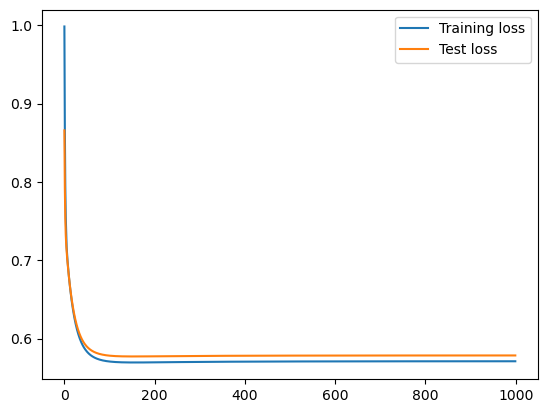

In [10]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

### Evaluation of accuracy for the training, validation and test set

In [11]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print('Training set accuracy:', training_accuracy,
      'Validation set accuracy:', valid_accuracy, 'Test set accuracy:', test_accuracy)

Training set accuracy: 0.71845 Validation set accuracy: 0.7036 Test set accuracy: 0.71692


Training set accuracy: 0.71845

Validation set accuracy: 0.7036 

Test set accuracy: 0.71692

### Weight analysis

In [15]:
model.classifier[0].state_dict()["weight"]

tensor([[-0.0337, -0.0450, -0.0096, -0.0271,  0.1671, -0.1827]])

What seems to impact the most are the number of words which are in the positive and negative lexicons.

### 2 wrongly classified samples

In [16]:
predicted_labels = p_test
count = 0
examples = ['','']
labels = [-1, -1]
true_labels = [-1, -1]
for i in range(len(dataset['test']['label'])):
    if count == 2:
        break
    if predicted_labels[i] != dataset['test']['label'][i]:
        examples[count] = dataset['test']['text'][i]
        labels[count] = predicted_labels[i]
        true_labels[count] = dataset['test']['label'][i]
        count += 1;
print(examples[0])
print('Vector features:', generateVectorFeatures(examples[0]))
print(true_labels[0], labels[0])

print(examples[1])
print('Vector features:', generateVectorFeatures(examples[1]))
print(true_labels[1], labels[1])

First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!
Vector features: [0, 4, 1, 5.017279836814924, 9, 2]
0 [1.]
Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always e

The model was wrong because there are much more positive words than negatives words in those samples.